# Loading data

Let's start by creating a _source_ dataset - it will be responsible for loading the data from disk.

First we'll gather the dataset entries and define a function that assigns a key to each entry. We'll just use the file name relative to the root folder:

In [1]:
from pathlib import Path
from connectome import Source, meta

# `Source` is the base class for all source datasets
class HeLa(Source):
    @meta
    def ids():
        root = Path('DIC-C2DH-HeLa')
        return sorted({str(f.relative_to(root)) for f in root.glob('*/*.tif')})

now we can create an instance and view the keys (or ids)

In [2]:
ds = HeLa()
ds.ids[:10]

['01/t000.tif',
 '01/t001.tif',
 '01/t002.tif',
 '01/t003.tif',
 '01/t004.tif',
 '01/t005.tif',
 '01/t006.tif',
 '01/t007.tif',
 '01/t008.tif',
 '01/t009.tif']

### Adding fields

Let's add some fields to our dataset so that it can do useful stuff:

In [3]:
import imageio


class HeLa(Source):
    @meta
    def ids():
        root = Path('DIC-C2DH-HeLa')
        return sorted({str(f.relative_to(root)) for f in root.glob('*/*.tif')})
    
    def image(key):
        root = Path('DIC-C2DH-HeLa')
        return imageio.imread(root / key)
    
    def mask(key):
        root = Path('DIC-C2DH-HeLa')
        path = key.replace('/t', '_ST/SEG/man_seg')
        return imageio.imread(root / path)

In [4]:
ds = HeLa()

What attributes does it have?

In [5]:
dir(ds)

['id', 'ids', 'image', 'mask']

(almost) what we expected - the `image`, the `mask`, and the `ids`. Ignore the `id` field for now, we'll cover it in another tutorial.

Let's load some data

In [6]:
key = ds.ids[0]
x = ds.image(key)
y = ds.mask(key)

In [7]:
x.shape, y.shape

((512, 512), (512, 512))

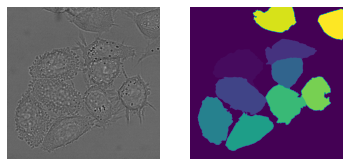

In [8]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.axis('off');

So, it looks like this is a dataset for cell instance segmentation.

### Data vs Meta-Data

You may have noticed the `meta` decorator applied to `ids`. Why did we use it?

Strictly speaking, the `ids` aren't a part of our dataset - they don't hold any instance-specific information, but they kind of describe the whole dataset. This is useful sometimes, for example when we want to know fow many objects are there in the dataset.

We decorate such functions with the `meta` decorator, because we don't want to confuse them with regular instance fields such as `image` and `mask`. As a neat side effect - all the `meta` functions are converted to properties, so you don't have to write

```python
dataset.ids()
```
but simply 
```python
dataset.ids
```

### Local parameters

Now we have a duplicated line in each function: `root = Path('DIC-C2DH-HeLa')`. Code duplication is not a good practice, so let's move it to a _local parameter_:

In [9]:
import imageio


class HeLa(Source):
    def _base():
        return Path('DIC-C2DH-HeLa')
    
    @meta
    def ids(_base):
        return sorted({str(f.relative_to(_base)) for f in _base.glob('*/*.tif')})
    
    def image(key, _base):
        return imageio.imread(_base / key)
    
    def mask(key, _base):
        path = key.replace('/t', '_ST/SEG/man_seg')
        return imageio.imread(_base / path)

Functions with underscores define local parameters, which cannot be accessed directly:

In [10]:
ds = HeLa()
dir(ds) # no `_base` here

['id', 'ids', 'image', 'mask']

but they can be requested by other functions, note the `_base` argument in ids/image/mask.
`connectome` analyzes functions' arguments and passes the requested values at runtime, no need to pass them manually.
So, e.g. `image` is still a function with a single argument:

In [11]:
# you can also use jupyter's function arguments inspections by pressing (Shift + Tab)
x = ds.image(key)

This approach is called [Inversion of Control](https://en.wikipedia.org/wiki/Inversion_of_control) and it lets you focus on specific parts of your pipeline without caring about their interraction. Cool!

You might be familiar with this approach if you ever used [pytest's fixtures](https://docs.pytest.org/en/latest/how-to/fixtures.html).

### Extenal parameters

We already have a pretty cool dataset, but in only works if the current working directory contains the `DIC-C2DH-HeLa` folder, let's fix that:

In [12]:
class HeLa(Source):
    _root: str
    
    def _base(_root):
        return Path(_root)
    
    @meta
    def ids(_base):
        return sorted({str(f.relative_to(_base)) for f in _base.glob('*/*.tif')})
    
    def image(key, _base):
        return imageio.imread(_base / key)
    
    def mask(key, _base):
        path = key.replace('/t', '_ST/SEG/man_seg')
        return imageio.imread(_base / path)

In [13]:
ds = HeLa(root='DIC-C2DH-HeLa')
x, y = ds.image(key), ds.mask(key)

We defined an external parameter, which allows us to further customize the dataset's behaviour. Now no matter where your code runs you can provide an adequate path to the data root:

```python
ds = HeLa(root='/some/absolute/path/to/my/data/DIC-C2DH-HeLa')
```

Each external parameter gets converted to an argument for `__init__` by losing the underscore. In our case the parameter `_root` becomes the argument `root`.

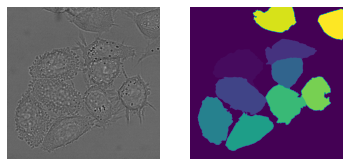

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.axis('off');

That's it. See you in the next tutorial!